## TODO: download the MNIST dataset

In [1]:
import numpy as np

import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
import utils
import layers

In [3]:
import importlib
importlib.reload(utils)
importlib.reload(layers)

<module 'layers' from '/content/layers.py'>

## Load Data

In [4]:
# adding color channels to mnist dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert [1, 28, 28] → [3, 28, 28]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.04MB/s]


## Data Preview

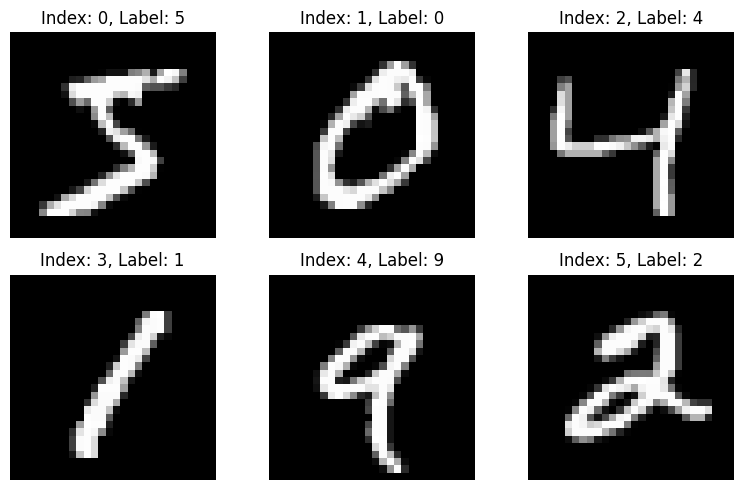

In [5]:
# Set up a 2x3 grid

fig, axes = plt.subplots(2, 3, figsize=(8, 5))

for i in range(6):
    image, label = train_dataset[i]
    tmp_img = image.permute(1, 2, 0)

    ax = axes[i // 3, i % 3]  # Convert index to 2D grid position
    ax.imshow(tmp_img)
    ax.set_title(f"Index: {i}, Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Build Neural Network

In [6]:
def train_loader(dataset, batch_size, shuffle=True):
    """
    Custom train loader function to modify data on the fly.
    """
    data_len = len(dataset)
    indices = list(range(data_len))
    if shuffle:
        np.random.shuffle(indices)

    for i in range(0, data_len, batch_size):
        batch_indices = indices[i : min(i + batch_size, data_len)]
        batch_data = []
        batch_labels = []
        for index in batch_indices:
          image, label = dataset[index]
          # Modify the image data here if needed, example:
          modified_image = image * 2 # Example modification
          batch_data.append(modified_image)
          batch_labels.append(label)

        yield torch.stack(batch_data), torch.tensor(batch_labels)



#Using the custom train loader
train_loader = train_loader(train_dataset, batch_size=64, shuffle=True)

In [7]:
# prompt: write custom test_loader

import numpy as np
def test_loader(dataset, batch_size, shuffle=False):
    """
    Custom test loader function to modify data on the fly.
    """
    data_len = len(dataset)
    indices = list(range(data_len))
    if shuffle:
        np.random.shuffle(indices)

    for i in range(0, data_len, batch_size):
        batch_indices = indices[i : min(i + batch_size, data_len)]
        batch_data = []
        batch_labels = []
        for index in batch_indices:
          image, label = dataset[index]
          # Modify the image data here if needed, example:
          modified_image = image / 2 # Example modification for test data
          batch_data.append(modified_image)
          batch_labels.append(label)

        yield torch.stack(batch_data), torch.tensor(batch_labels)
#Using the custom test loader
test_loader = test_loader(test_dataset, batch_size=64, shuffle=False)


In [12]:
class ann:
    def __init__(self):
        self.conv1 = layers.Conv2D(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = layers.Conv2D(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.fc1 = layers.Dense(input_size=32 * 7 * 7, output_size=128)
        self.fc2 = layers.Dense(input_size=128, output_size=10)

        self.maxPool1 = layers.MaxPool2D(kernel_size=2, stride=2)
        self.maxPool2 = layers.MaxPool2D(kernel_size=2, stride=2)

        self.flatten = layers.Flatten()

    def forward(self, x):
        x = utils.relu(self.conv1.forward(x))
        print("finished forward pass conv1")

        x = self.maxPool1.forward(x)
        print("maxpool1")

        x = utils.relu(self.conv2.forward(x))
        print("relu")

        x = self.maxPool2.forward(x)
        print("maxpool2")


        x = self.flatten.forward(x)
        print("flatten")

        x = utils.relu(self.fc1.forward(x))
        print("relu")

        x = self.fc2.forward(x)
        print("fc2")

        return np.argmax(x, axis=1) + 1

In [9]:
image, label = train_dataset[4]

network = ann()
predicted_y = network.forward(image.unsqueeze(0))
print(predicted_y)

[6]


## Training

In [13]:
def train_loop(model, train_loader, epochs=10, learning_rate=0.001):
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
          # Assuming train_loader yields (images, labels)
          # Convert to numpy if needed
          images = images.numpy()
          labels = labels.numpy()

          # Forward pass
          outputs = []
          for image in images:
            # Add a batch dimension to the image
            image = image[None, ...]  # or image = np.expand_dims(image, axis=0)
            outputs.append(model.forward(image))

          outputs = np.array(outputs)
          # Calculate loss (example using mean squared error)
          loss = np.mean(np.square(outputs - labels))
          total_loss += loss

          # Calculate accuracy
          predictions = np.round(outputs)
          correct_predictions += np.sum(predictions == labels)
          total_samples += len(labels)
          # Backpropagation (simplified example, no gradient descent)
          # In a real scenario you would update weights based on gradients here.
          # ... (update model weights using a gradient-based optimizer)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


train_loop(network, train_loader, 10, 0.001)

KeyboardInterrupt: 

In [ ]:
# prompt: write the test_loop not the train_loop

def test_loop(model, test_loader):
    correct_predictions = 0
    total_samples = 0

    for images, labels in test_loader:
        images = images.numpy()
        labels = labels.numpy()

        outputs = []
        for image in images:
            image = image[None, ...]
            outputs.append(model.forward(image))

        outputs = np.array(outputs)
        predictions = np.round(outputs)
        correct_predictions += np.sum(predictions == labels)
        total_samples += len(labels)

    accuracy = correct_predictions / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")

test_loop(network, test_loader)
